In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

# TicTacToe Game Setup
In this setup, we play on both sides, i.e., we decide what to play as players take turn. The algorithm calculates when a player wins or there's no move to make (draw) and terminates the game.

In [64]:
class TicTacToe(object):
    def __init__(self, board_size=3):
        self.board_size = board_size

    def init_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def next_state(self, state, action, player):
        assert player in {-1, 1}, "player must be 1 or -1."
        assert state.shape == (self.board_size, self.board_size), "incorrect state shape!"
        row, col = self.coord(action)
        state[row, col] = player
        return state

    def coord(self, action):
        assert action >= 0 and action < self.board_size**2, "invalid action number!"
        return action//self.board_size, action%self.board_size
    
    def won(self, state, action):
        assert state.shape == (self.board_size, self.board_size), "incorrect state shape!"
        row, col = self.coord(action)
        player = state[row, col]
        assert player != 0, "player hasn't played yet!"

        row_full = np.sum(state[row, :]) == player * self.board_size
        col_full = np.sum(state[:, col]) == player * self.board_size
        diag_full = np.sum(np.diag(state)) == player * self.board_size
        offdiag_full = np.sum(np.diag(np.fliplr(state))) == player * self.board_size
    
        return row_full or col_full or diag_full or offdiag_full
        
    def valid_moves(self, state):
        return np.where(state.reshape(-1) == 0)[0]

    def is_over(self, state, action):
        return self.won(state, action) or (np.sum(state == 0) == 0)

    def opponent(self, player):
        assert player in {-1, 1}, "player must be 1 or -1."
        return -player
    
    def value(self, action):
        row, col = self.coord(action)
        return self.state[row, col]

In [67]:
t3 = TicTacToe()
state = t3.init_state()
player = 1

while True:
    print(state)
    print(f"player '{player}' to play...")

    valid_moves = t3.valid_moves(state)
    print(f"valid moves: {valid_moves}")
    
    if len(valid_moves) == 0:
        print("draw!")
        break        

    action = input(f"provide a valid move: ")
    action = int(action)
    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print(state)
        print(f"player {player} won!")
        break
    
    player = t3.opponent(player)


[[0 0 0]
 [0 0 0]
 [0 0 0]]
player '1' to play...
valid moves: [0 1 2 3 4 5 6 7 8]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
player '-1' to play...
valid moves: [0 1 2 3 5 6 7 8]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0  0]]
player '1' to play...
valid moves: [1 2 3 5 6 7 8]
[[-1  0  0]
 [ 0  1  0]
 [ 0  1  0]]
player '-1' to play...
valid moves: [1 2 3 5 6 8]
[[-1 -1  0]
 [ 0  1  0]
 [ 0  1  0]]
player '1' to play...
valid moves: [2 3 5 6 8]
[[-1 -1  1]
 [ 0  1  0]
 [ 0  1  0]]
player '-1' to play...
valid moves: [3 5 6 8]
[[-1 -1  1]
 [ 0  1  0]
 [-1  1  0]]
player '1' to play...
valid moves: [3 5 8]
[[-1 -1  1]
 [ 0  1  1]
 [-1  1  0]]
player '-1' to play...
valid moves: [3 8]
[[-1 -1  1]
 [ 0  1  1]
 [-1  1 -1]]
player '1' to play...
valid moves: [3]
[[-1 -1  1]
 [ 0  1  1]
 [-1  1  1]]
player 1 won!


# Monte Carlo Tree Search
In this setion, we play against the machine. The machine uses Monte Carlo Tree Search (MCTS) to decide on the next move.

In [140]:
params = {
    "C": np.sqrt(2),
    "num_iters": 1000,
}

In [176]:

class Node(object):
    def __init__(self, game, state, action, params, parent=None):
        self.game = game
        self.state = state
        self.action = action
        self.params = params

        self.parent = parent
        self.children = []
        self.available_actions = (state.reshape(-1) == 0).astype(np.int8)

        # reward value for the current state which can be positive or negative.
        self.value_sum = 0
        self.visit_count = 0
    
    def win_prob(self):
        return (self.value_sum/self.visit_count + 1)/2

    def ucb(self, child):
        '''
        Computes the Upper Confidence Bound.
        '''
        parent_win_prob = 1 - child.win_prob()
        return parent_win_prob + self.params["C"]*np.sqrt(np.log(self.visit_count)/child.visit_count)

    def select(self):
        k = np.argmax([self.ucb(child) for child in self.children])
        return self.children[k]
    
    def is_fully_expanded(self):
        '''
        Used in the node selection. Starting from the root, we select a child node
        which is fully expanded. We continue this process until we reach a node that
        is not fully expanded. Then, we expand the node.
        '''
        return (np.sum(self.available_actions) == 0) and len(self.children) > 0
    
    def expand(self):
        child_action = np.random.choice(np.where(self.available_actions > 0)[0])
        self.available_actions[child_action] = 0
        child_state = self.game.next_state(self.state.copy(), child_action, 1)
        child_state = self.game.change_perspective(child_state)

        child_node = Node(self.game, child_state, child_action, self.params, parent=self)
        self.children.append(child_node)
        return child_node

    def simulate(self):
        next_state = self.state.copy()
        player = 1
        
        while True:
            action = np.random.choice(np.where(next_state.reshape(-1) == 0)[0])
            next_state = self.game.next_state(next_state, action, player)           
            game_is_over, value = self.game.is_over(next_state, action)

            if game_is_over:
                if player == 1:
                    value = self.game.opponent_value(value)
                return value

            player = self.game.opponent(player)
            
       
    def backward(self, value):
        value = self.game.opponent_value(value)
        self.value_sum += value
        self.visit_count += 1
        
        if self.parent is not None:
            self.parent.backward(value)
        

class MCTS(object):
    '''
    Monte Carlo Tree Search implementation. It has no notion of players. It sees the state
    from the perspective of player 1. This is useful when two machines play as we can just
    change the perspective.
    '''
    def __init__(self, game, params):
        self.game = game
        self.params = params
        
    def search(self, state, num_iters):
        action = None
        root = Node(self.game, state, action, self.params)
        for _ in range(num_iters):
            node = root

            while node.is_fully_expanded():
                node = node.select()
            
            game_is_over, value = self.game.is_over(node.state, node.action)

            if not game_is_over:
                node = node.expand()
                game_is_over, value = self.game.is_over(node.state, node.action)

                if not game_is_over:
                    value = node.simulate()
                
            node.backward(value)
                
        return self.action_dist(root)

    def action_dist(self, root):
        '''
        Returns the probability distribution of the visit counts.
        '''
        out = np.zeros(self.game.board_size**2)
        for child in root.children:
            out[child.action] = child.visit_count
        out /= np.sum(out)
        return out        


In [177]:
class TicTacToe(object):
    def __init__(self, board_size=3):
        self.board_size = board_size
        self.first_player = 1

    def init_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def next_state(self, state, action, player):
        assert player in {-1, 1}, "player must be 1 or -1."
        assert state.shape == (self.board_size, self.board_size), "incorrect state shape!"
        row, col = self.coord(action)
        state[row, col] = player
        return state

    def coord(self, action):
        assert action >= 0 and action < self.board_size**2, "invalid action number!"
        return action//self.board_size, action%self.board_size
    
    def won(self, state, action):
        if action is None:
            return False
        assert state.shape == (self.board_size, self.board_size), "incorrect state shape!"
        row, col = self.coord(action)
        player = state[row, col]
        assert player != 0, "player hasn't played yet!"

        row_full = np.sum(state[row, :]) == player * self.board_size
        col_full = np.sum(state[:, col]) == player * self.board_size
        diag_full = np.sum(np.diag(state)) == player * self.board_size
        offdiag_full = np.sum(np.diag(np.fliplr(state))) == player * self.board_size
    
        return row_full or col_full or diag_full or offdiag_full
        
    def valid_moves(self, state):
        return np.where(state.reshape(-1) == 0)[0]

    def is_over(self, state, action):
        '''
        Return a pair (game_over, value) for the current state.
        (True, 1) means game over and the player won.
        (True, 0) means game over and is draw.
        (False, 0) means game is not over.
        '''
        if self.won(state, action):
            return True, 1
        return (np.sum(state == 0) == 0), 0

    def opponent(self, player):
        assert player in {-1, 1}, "player must be 1 or -1."
        return -player
    
    def opponent_value(self, value):
        return -value
    
    def change_perspective(self, state):
        return -state 
    
    def value(self, state, action):
        if action is None:
            return self.first_player
        row, col = self.coord(action)
        return state[row, col]

## Human-Machine Play

[[0 0 0]
 [0 0 0]
 [0 0 0]]
player '1' to play...
valid moves: [0 1 2 3 4 5 6 7 8]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
player '-1' to play...
valid moves: [0 1 2 3 5 6 7 8]


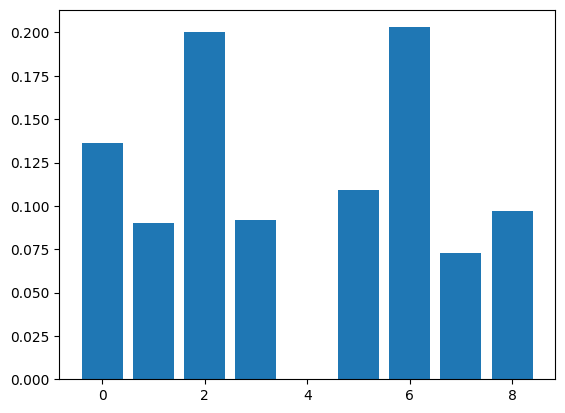

[[ 0  0  0]
 [ 0  1  0]
 [-1  0  0]]
player '1' to play...
valid moves: [0 1 2 3 5 7 8]
[[ 0  0  0]
 [ 0  1  0]
 [-1  1  0]]
player '-1' to play...
valid moves: [0 1 2 3 5 8]


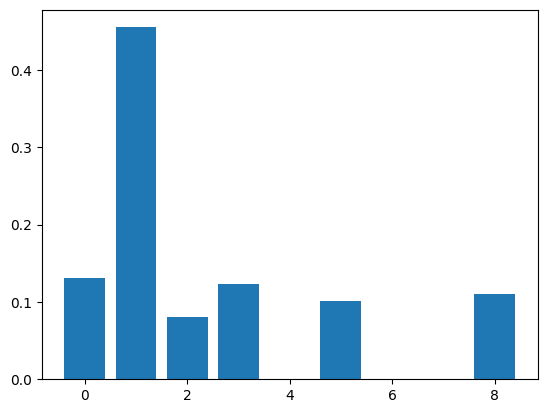

[[ 0 -1  0]
 [ 0  1  0]
 [-1  1  0]]
player '1' to play...
valid moves: [0 2 3 5 8]
[[ 1 -1  0]
 [ 0  1  0]
 [-1  1  0]]
player '-1' to play...
valid moves: [2 3 5 8]


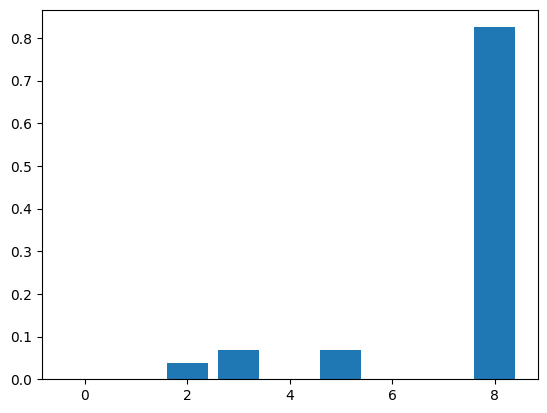

[[ 1 -1  0]
 [ 0  1  0]
 [-1  1 -1]]
player '1' to play...
valid moves: [2 3 5]
[[ 1 -1  0]
 [ 1  1  0]
 [-1  1 -1]]
player '-1' to play...
valid moves: [2 5]


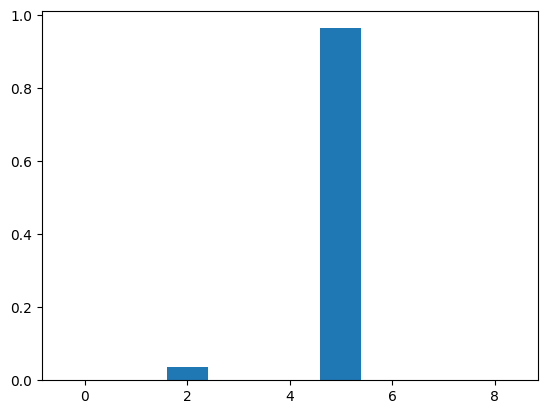

[[ 1 -1  0]
 [ 1  1 -1]
 [-1  1 -1]]
player '1' to play...
valid moves: [2]
[[ 1 -1  1]
 [ 1  1 -1]
 [-1  1 -1]]
player '-1' to play...
valid moves: []
draw!


In [178]:
t3 = TicTacToe()
state = t3.init_state()
player = 1  # or -1

mcts = MCTS(t3, params)

while True:
    print(state)
    print(f"player '{player}' to play...")

    valid_moves = t3.valid_moves(state)
    print(f"valid moves: {valid_moves}")
    
    if len(valid_moves) == 0:
        print("draw!")
        break        

    if player == 1:
        action = input(f"provide a valid move: ")
        action = int(action)
    else:
        # mcts sees the state from the perspective of player 1.
        # since it's player -1 now, we change the perspective.
        opponent_state = t3.change_perspective(state)
        action_dist = mcts.search(opponent_state, params["num_iters"])
        plt.bar(range(len(action_dist)), action_dist)
        plt.show()
        action = np.argmax(action_dist)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print(state)
        print(f"player {player} won!")
        break
    
    player = t3.opponent(player)


## Machine-Machine Play

[[0 0 0]
 [0 0 0]
 [0 0 0]]
player '1' to play...
valid moves: [0 1 2 3 4 5 6 7 8]


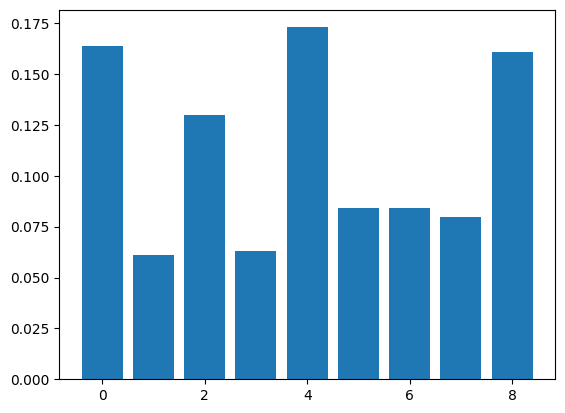

[[0 0 0]
 [0 1 0]
 [0 0 0]]
player '-1' to play...
valid moves: [0 1 2 3 5 6 7 8]


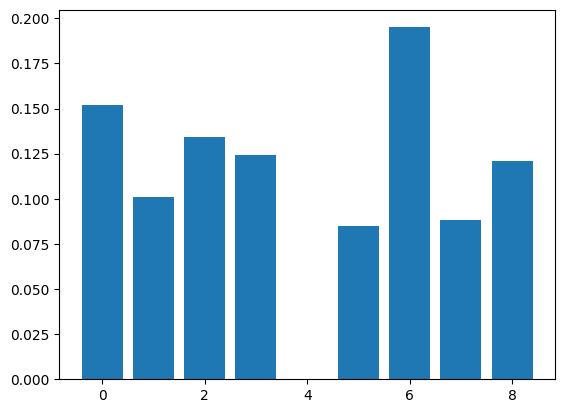

[[ 0  0  0]
 [ 0  1  0]
 [-1  0  0]]
player '1' to play...
valid moves: [0 1 2 3 5 7 8]


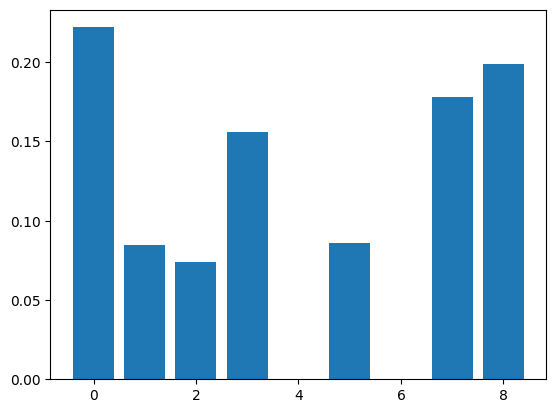

[[ 1  0  0]
 [ 0  1  0]
 [-1  0  0]]
player '-1' to play...
valid moves: [1 2 3 5 7 8]


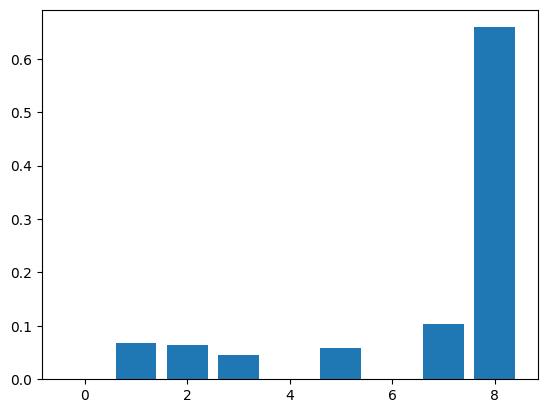

[[ 1  0  0]
 [ 0  1  0]
 [-1  0 -1]]
player '1' to play...
valid moves: [1 2 3 5 7]


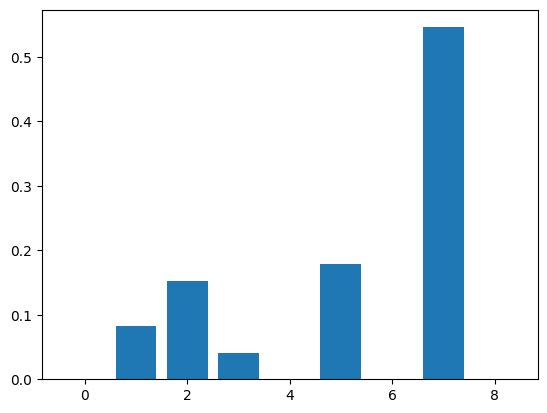

[[ 1  0  0]
 [ 0  1  0]
 [-1  1 -1]]
player '-1' to play...
valid moves: [1 2 3 5]


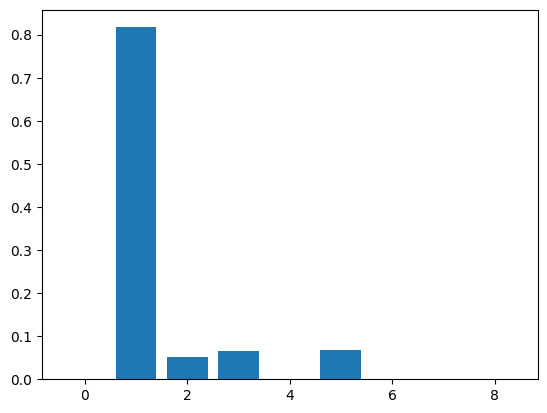

[[ 1 -1  0]
 [ 0  1  0]
 [-1  1 -1]]
player '1' to play...
valid moves: [2 3 5]


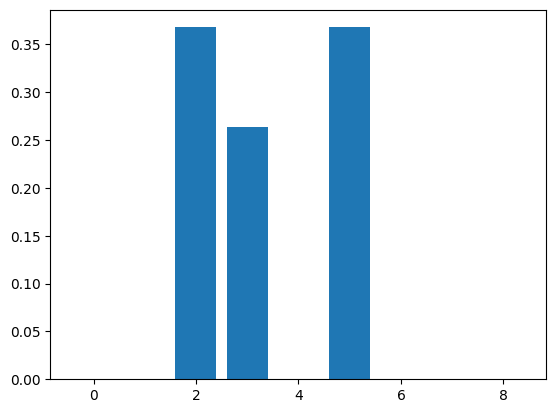

[[ 1 -1  1]
 [ 0  1  0]
 [-1  1 -1]]
player '-1' to play...
valid moves: [3 5]


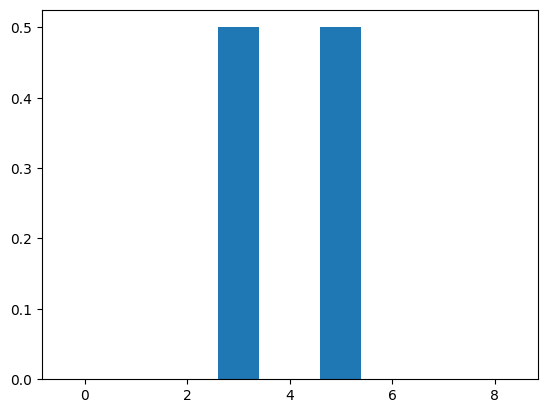

[[ 1 -1  1]
 [-1  1  0]
 [-1  1 -1]]
player '1' to play...
valid moves: [5]


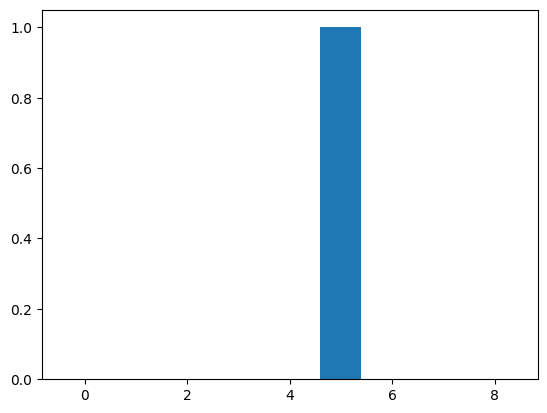

[[ 1 -1  1]
 [-1  1  1]
 [-1  1 -1]]
player '-1' to play...
valid moves: []
draw!


In [179]:
t3 = TicTacToe()
state = t3.init_state()
player = 1  # or -1

mcts = MCTS(t3, params)

while True:
    print(state)
    print(f"player '{player}' to play...")

    valid_moves = t3.valid_moves(state)
    print(f"valid moves: {valid_moves}")
    
    if len(valid_moves) == 0:
        print("draw!")
        break        

    # mcts sees the state from the perspective of player 1.
    # since it's player -1 now, we change the perspective.
    opponent_state = t3.change_perspective(state)
    action_dist = mcts.search(opponent_state, params["num_iters"])
    plt.bar(range(len(action_dist)), action_dist)
    plt.show()
    action = np.argmax(action_dist)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print(state)
        print(f"player {player} won!")
        break
    
    player = t3.opponent(player)
